#  Evaluating Performance of Trained Conditioned Normalizing Flows for Climate Variable Downscaling
In this notebook, we will evaluate the performance of trained conditioned normalizing flows (CNFs) for downscaling climate variables. Conditioned normalizing flows are a powerful class of generative models that learn to map a simple distribution (e.g., Gaussian) to a complex target distribution by conditioning on additional information, such as low-resolution climate data. The main objective of this evaluation is to assess how well the trained CNF model can downscale climate variables, such as temperature, precipitation, or humidity, from coarse-resolution to fine-resolution spatial grids.


In [2]:
import torch
import numpy as np
import random
from models.architectures import srgan, srflow
import PIL
import os
import torchvision
from torchvision import transforms
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

# Dataset loading
from data import dataloading
from data.era5_temp_dataset import InverseMinMaxScaler

from os.path import exists, join
import matplotlib.pyplot as plt
from matplotlib import transforms
import timeit
import pdb
import argparse
import seaborn as sns

from utils.metrics import *

# %load_ext autoreload
# %autoreload 2

In [3]:
print('GPUs avail:', torch.cuda.device_count())

# Parse Settings
parser = argparse.ArgumentParser()

# train configs
parser.add_argument("--model", type=str, default="srflow",
                    help="Model you want to train.")
parser.add_argument("--modeltype", type=str, default="srflow",
                    help="Specify modeltype you would like to train [srflow, cdiff, srgan].")
parser.add_argument("--model_path", type=str, default="runs/",
                    help="Directory where models are saved.")
parser.add_argument("--modelname", type=str, default=None,
                    help="Sepcify modelname to be tested.")
parser.add_argument("--epochs", type=int, default=10000,
                    help="number of epochs")
parser.add_argument("--max_steps", type=int, default=2000000,
                    help="For training on a large dataset.")
parser.add_argument("--log_interval", type=int, default=100,
                    help="Interval in which results should be logged.")

# runtime configs
parser.add_argument("--visual", action="store_true",
                    help="Visualizing the samples at test time.")
parser.add_argument("--noscaletest", action="store_true",
                    help="Disable scale in coupling layers only at test time.")
parser.add_argument("--noscale", action="store_true",
                    help="Disable scale in coupling layers.")
parser.add_argument("--testmode", action="store_true",
                    help="Model run on test set.")
parser.add_argument("--train", action="store_true",
                    help="If model should be trained.")
parser.add_argument("--resume_training", action="store_true",
                    help="If training should be resumed.")
parser.add_argument("--constraint", type=str, default='scaddDS',
                    help="Physical Constraint to be applied during training.")                   

# hyperparameters
parser.add_argument("--nbits", type=int, default=8,
                    help="Images converted to n-bit representations.")
parser.add_argument("--s", type=int, default=16, help="Upscaling factor.")
parser.add_argument("--bsz", type=int, default=16, help="batch size")
parser.add_argument("--lr", type=float, default=0.0002, help="learning rate")
parser.add_argument("--filter_size", type=int, default=512, help="filter size NN in Affine Coupling Layer")
parser.add_argument("--L", type=int, default=3, help="# of levels")
parser.add_argument("--K", type=int, default=2,
                    help="# of flow steps, i.e. model depth")
parser.add_argument("--nb", type=int, default=16,
                    help="# of residual-in-residual blocks LR network.")
parser.add_argument("--condch", type=int, default=128//8,
                    help="# of residual-in-residual blocks in LR network.")

# data
parser.add_argument("--datadir", type=str, default="/home/christina/Documents/clim-var-ds-cnf-own/data/",
                    help="Dataset to train the model on.")
parser.add_argument("--trainset", type=str, default="era5-TCW", help='[era5-TCW, era5-T2M]')
parser.add_argument("--testset", type=str, default="era5-TCW", help="Specify test dataset")

args = parser.parse_args('')
config = vars(args)

GPUs avail: 1


### Load ERA5 Watercontent Data

In [3]:
# Load testset
train_loader,val_loader, test_loader, args = dataloading.load_data(args)

in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]

if torch.cuda.is_available():
    args.device = torch.device("cuda")
    args.num_gpus = torch.cuda.device_count()
    args.parallel = False

else:
    args.device = "cpu"

Loading ERA5 TCW ...


### Exploratory Analysis

In [4]:
# Initialize lists to accumulate pixel values for each channel
all_unnorm_pixels = {0: []}  # Adjust the dictionary based on the number of channels

for idx, item in enumerate(train_loader):
    images = item[2]
    if idx == 20:
        break
    for channel in range(images.size(1)):
        all_unnorm_pixels[channel].append(images[:, channel, :, :].view(-1))

In [5]:
# Concatenate all pixel values for each channel
for channel in all_unnorm_pixels:
    all_unnorm_pixels[channel] = torch.cat(all_unnorm_pixels[channel])

In [6]:
# compute min max std mean median

In [7]:
# Convert dictionary values to a list of lists (assuming same number of pixels per sample)
pixel_list = list(all_unnorm_pixels.values())

# Convert to a PyTorch tensor
all_unnorm_pixels_tensor = pixel_list[0]

In [8]:
# Compute statistics
min_value = torch.min(all_unnorm_pixels_tensor).item()
max_value = torch.max(all_unnorm_pixels_tensor).item()
mean_value = torch.mean(all_unnorm_pixels_tensor).item()
std_deviation = torch.std(all_unnorm_pixels_tensor).item()
median_value = torch.median(all_unnorm_pixels_tensor.float()).item()  # Median requires float tensor

# Compute variance using PyTorch
variance = torch.var(all_unnorm_pixels_tensor.float()).item()

# Compute percentiles using NumPy (as PyTorch does not have built-in percentile function)
percentiles = np.percentile(all_unnorm_pixels_tensor.numpy(), [25, 50, 75])  # Change the percentiles as needed

# Print the results
print(f"Minimum pixel value: {min_value}")
print(f"Maximum pixel value: {max_value}")
print(f"Mean pixel value: {mean_value}")
print(f"Standard deviation of pixel values: {std_deviation}")
print(f"Median pixel value: {median_value}")
print(f"Variance of pixel values: {variance}")
print(f"25th, 50th (median), and 75th percentiles: {percentiles}")

Minimum pixel value: 0.08208853006362915
Maximum pixel value: 116.74315643310547
Mean pixel value: 23.267269134521484
Standard deviation of pixel values: 17.56329345703125
Median pixel value: 18.281330108642578
Variance of pixel values: 308.4692687988281
25th, 50th (median), and 75th percentiles: [ 8.75240898 18.28133011 35.74177551]


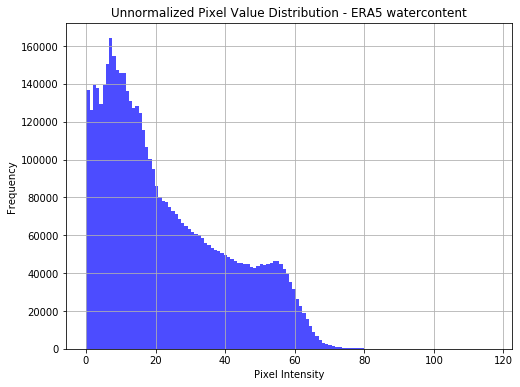

In [9]:
# Flatten the tensor to 1D for boxplot
all_unnorm_pixels_flat = all_unnorm_pixels_tensor.view(-1).numpy()

# Plot histogram of pixel values
plt.figure(figsize=(8, 6))
plt.hist(all_unnorm_pixels_flat, bins=124, color='blue', alpha=0.7)
plt.title('Unnormalized Pixel Value Distribution - ERA5 watercontent')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('./data-analysis/unnorm_pix_val_distr_watercontent___.png')
plt.show()

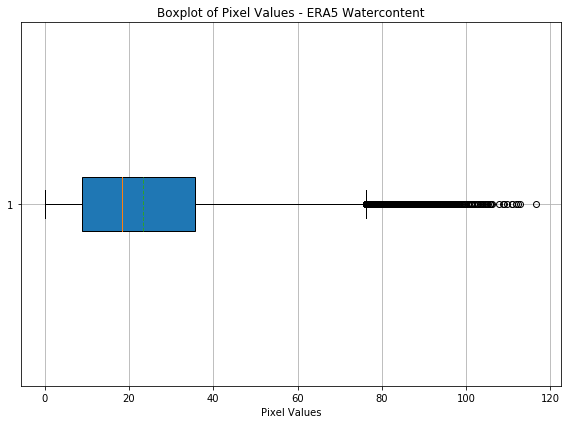

In [10]:
# Plot a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(all_unnorm_pixels_flat, vert=False, patch_artist=True, meanline=True, showmeans=True)
plt.title('Boxplot of Pixel Values - ERA5 Watercontent')
plt.xlabel('Pixel Values')
plt.grid(True)
plt.tight_layout()

# Save the plot if needed
plt.savefig('./data-analysis/pixel_values_watercontent_boxplot.png')

# Show plot
plt.show()

In [11]:
torch.max(all_unnorm_pixels_tensor)
top_values, top_indices = torch.topk(all_unnorm_pixels_tensor, k=4)

In [12]:
print(top_values, top_indices)

tensor([116.7432, 112.8495, 112.2727, 111.8289]) tensor([ 839538,  839409, 4778493, 4778492])


In [3]:
# use min-max due to non-gaussian distribution of data and outlier handling
def min_max_scaler(x, min_val=0, max_val=124):
    if min_val is None:
        min_val = x.min()
    if max_val is None:
        max_val = x.max()
    scaled_x = (x - min_val) / (max_val - min_val)
    return scaled_x, min_val, max_val

def inv_min_max_scaler(scaled_x, min_val=0, max_val=124):
    x = scaled_x * (max_val - min_val) + min_val
    return x

In [14]:
images.shape

torch.Size([16, 1, 128, 128])

In [15]:
# Min-max scaler example
scaled_data, min_val, max_val = min_max_scaler(images, min_val=0, max_val=124)
# print("Scaled data (min-max scaler):", scaled_data)
original_data = inv_min_max_scaler(scaled_data, min_val=0, max_val=124)
# print("Original data (min-max scaler):", original_data)
print((images-original_data).sum())

tensor(-0.0001)


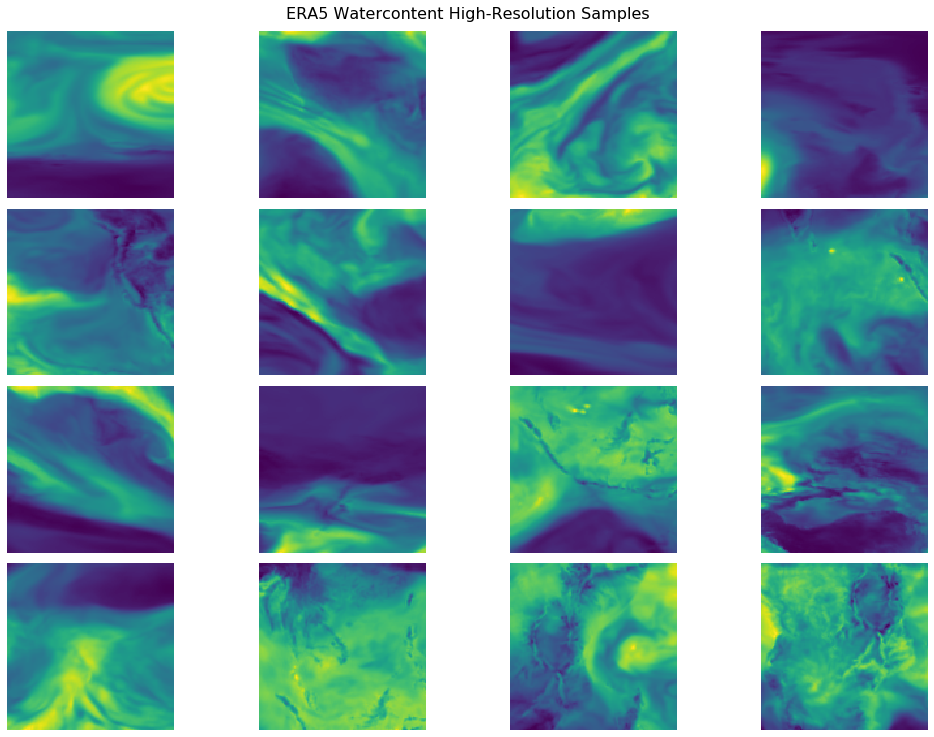

In [16]:
def plot_images(images, title='', save_path=None, figsize=(15, 10)):
    num_images = images.shape[0]
    rows = int(num_images ** 0.5)  # Square root of number of images for rows
    cols = (num_images + rows - 1) // rows  # Ensure enough columns

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(num_images):
        image = images[i].squeeze().numpy()  # Squeeze to remove single channel dimension
        axes[i].imshow(image, cmap='viridis')  # Plot grayscale image with viridis colormap
        axes[i].axis('off')

    # Set title
    fig.suptitle(title, fontsize=16, y=1.02)

    # Hide any remaining axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    # Save figure if save_path is provided
    if save_path:
        plt.savefig(save_path)

    plt.show()

# Plot the images from the tensor with title and save the figure
plot_images(images, title='ERA5 Watercontent High-Resolution Samples', save_path='./data-analysis/pixel_values_watercontent_samples.png')

### Metric Evaluation
Evaluations: 
- CNF unconstrained vs. constrained
- CNF vs. GAN vs. CDiff
- Residual Error Plots for ???
- Metrics for 2x,4x,8x,16x with and without constraints

In [4]:
import os
import json
import torch
import torchvision.utils as vutils
import sys
sys.path.append("../../")
from utils import metrics

def save_snapshot(tensor, path):
    # Function to save tensor as image in Viridis color scheme
    plt.figure()
    plt.imshow(tensor[0,...].cpu().numpy().squeeze(), cmap='viridis')
    plt.axis('off')
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

def save_grid_images(tensor_batch, save_path, nrow=3, title=None):
    
    # Create a grid of images
    grid_img = vutils.make_grid(tensor_batch[0:9], nrow=nrow, normalize=True, scale_each=True)

    # Convert the grid to numpy and plot
    np_grid = grid_img.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid[:, :, 0], cmap='viridis')  # Use Viridis colormap for grayscale images
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)

    # Save the grid image
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
def metric_eval(dataloader, model, exp_name, args):
    metric_dict = {
        'rmse0': [], 'mse0': [], 'mae0': [],
        'rmse05': [], 'mse05': [], 'mae05': [],
        'rmse08': [], 'mse08': [], 'mae08': [],
        'rmse1': [], 'mse1': [], 'mae1': [],
        'crps': []
    }

    # Create directories
    results_dir = os.path.join(exp_name, 'experiment_results')
    os.makedirs(results_dir, exist_ok=True)
    
    snapshots_dir = os.path.join(results_dir, 'snapshots')
    os.makedirs(snapshots_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unorm = item[3].to(args.device)

            z, _ = model.forward(x_hr=y, xlr=x)

            # Evaluate for different temperatures
            mu0, _, _ = model(xlr=x, reverse=True, eps=0)
            mu05, _, _ = model(xlr=x, reverse=True, eps=0.5)
            mu08, _, _ = model(xlr=x, reverse=True, eps=0.8)
            mu1, _, _ = model(xlr=x, reverse=True, eps=1.0)

            # Compute and store MSE for each temperature
            mse0 = metrics.MSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mse05 = metrics.MSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mse08 = metrics.MSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mse1 = metrics.MSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()
            
            metric_dict['mse0'].append(mse0)
            metric_dict['mse05'].append(mse05)
            metric_dict['mse08'].append(mse08)
            metric_dict['mse1'].append(mse1)

            # Compute and store MAE for each temperature
            mae0 = metrics.MAE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mae05 = metrics.MAE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mae08 = metrics.MAE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mae1 = metrics.MAE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['mae0'].append(mae0)
            metric_dict['mae05'].append(mae05)
            metric_dict['mae08'].append(mae08)
            metric_dict['mae1'].append(mae1)

            # Compute and store RMSE for each temperature
            rmse0 = metrics.RMSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            rmse05 = metrics.RMSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            rmse08 = metrics.RMSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            rmse1 = metrics.RMSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['rmse0'].append(rmse0)
            metric_dict['rmse05'].append(rmse05)
            metric_dict['rmse08'].append(rmse08)
            metric_dict['rmse1'].append(rmse1)

            # Save grid of images for visualization (adjust as needed)
            if batch_idx == 0:  # Save only for the first batch for simplicity
                # Save snapshots
                save_grid_images(y_unorm, os.path.join(snapshots_dir, f'ground_truth_{batch_idx}.png'))
                save_grid_images(mu0, os.path.join(snapshots_dir, f'prediction_mu0_{batch_idx}.png'))
                save_grid_images(mu05, os.path.join(snapshots_dir, f'prediction_mu05_{batch_idx}.png'))
                save_grid_images(mu08, os.path.join(snapshots_dir, f'prediction_mu08_{batch_idx}.png'))
                save_grid_images(mu1, os.path.join(snapshots_dir, f'prediction_mu1_{batch_idx}.png'))
                save_grid_images(x_unorm, os.path.join(snapshots_dir, f'low_res_{batch_idx}.png'))

            # Calculate CRPS for ensemble
            crps_stack = torch.stack([mu0, mu05, mu08, mu1], dim=1)
            metric_dict['crps'].append(crps_ensemble(y_unorm, crps_stack))
            
            print(f'Current RMSE - mu0: {rmse0}, mu05: {rmse05}, mu08: {rmse08}, mu1: {rmse1}')
            print(f'Current MAE - mu0: {mae0}, mu05: {mae05}, mu08: {mae08}, mu1: {mae1}')
            print(f'Current CRPS:{ crps_ensemble(y_unorm, crps_stack).mean()}')

            if batch_idx == 200:
                break

    # Create a string representation of the metric_dict
    mean_dict = {}
    for key, value in metric_dict.items():
        if len(value) > 0:
            mean_dict[key] = np.mean(value)   
            
    metric_str = "\n".join([f"{key}: {value}" for key, value in mean_dict.items()])

    # Save metric_dict to a text file
    with open(os.path.join(results_dir, 'metrics.txt'), 'w') as f:
        json.dump(metric_str, f, indent=4)
        
    print(metric_dict)
    return metric_dict

### Bicubic Baseline

In [6]:
def bicubic_interpolation(x_lr, scale_factor):
    # Implement bicubic interpolation here using torchvision.transforms.functional.resize
    # Example: Replace this with your actual bicubic interpolation function
    x_hr = torch.nn.functional.interpolate(x_lr, scale_factor=scale_factor, mode='bicubic', align_corners=False)
    return x_hr

In [7]:
def eval_bicubic(dataloader, exp_name='bicubic-interpolation', scale=2.0):
    metric_dict = {'rmse': [], 'mse': [], 'mae': []}

    # Create directories
    results_dir = os.path.join(exp_name, 'experiment_results')
    os.makedirs(results_dir, exist_ok=True)
    
    snapshots_dir = os.path.join(results_dir, 'snapshots')
    os.makedirs(snapshots_dir, exist_ok=True)

    args.device = 'cuda'

    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            
            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unorm = item[3].to(args.device)

            # Perform bicubic interpolation for each scale factor
            mu0 = bicubic_interpolation(x, scale_factor=scale)

            # Compute and store MSE for each temperature
            mse = metrics.MSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            metric_dict['mse'].append(mse)
        
            mae = metrics.MAE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            metric_dict['mae'].append(mae)

            # Compute and store RMSE for each temperature
            rmse = metrics.RMSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            metric_dict['rmse'].append(rmse)

            # Save grid of images for visualization (adjust as needed)
            if batch_idx == 0:  # Save only for the first batch for simplicity
                # Save snapshots
                save_grid_images(y_unorm, os.path.join(snapshots_dir, f'ground_truth_{batch_idx}.png'))
                save_grid_images(mu0, os.path.join(snapshots_dir, f'prediction_mu0_{batch_idx}.png'))
                save_grid_images(x_unorm, os.path.join(snapshots_dir, f'low_res_{batch_idx}.png'))
                
        # Create a string representation of the metric_dict
        mean_dict = {}
        for key, value in metric_dict.items():
            if len(value) > 0:
                mean_dict[key] = np.mean(value)   
                
        metric_str = "\n".join([f"{key}: {value}" for key, value in mean_dict.items()])
    
        # Save metric_dict to a text file
        with open(os.path.join(results_dir, 'metrics.txt'), 'w') as f:
            json.dump(metric_str, f, indent=4)
        
        return mean_dict

In [8]:
# args.s = 2
# train_loader,val_loader, test_loader, args = dataloading.load_data(args)
# eval_bicubic(test_loader, exp_name='./runs/bicubic-interpolation-2', scale=2.0)

In [9]:
# args.s = 4
# train_loader,val_loader, test_loader, args = dataloading.load_data(args)
# eval_bicubic(test_loader, exp_name='./runs/bicubic-interpolation-4', scale=4.0)

In [10]:
# args.s = 8
# train_loader,val_loader, test_loader, args = dataloading.load_data(args)
# eval_bicubic(test_loader, exp_name='./runs/bicubic-interpolation-8', scale=8.0)

In [11]:
# args.s = 16
# train_loader,val_loader, test_loader, args = dataloading.load_data(args)
# eval_bicubic(test_loader, exp_name='./runs/bicubic-interpolation-16', scale=16.0)

# Experiments: Comparing across upsampling factors

In [12]:
# first experiment: load 2x model for CNF with each constraint and without. See if the predictions improve when having the constraint.

In [13]:
# plot unnormalized pixel value distributions!!!!

In [14]:
# see the effect of epsilon sampling parameter on extreme value prediction 

In [15]:
# train flow with Laplace prior quickly to show advantage of this

In [16]:
import torch
import torch.distributions as D

class LaplacePrior:
    def __init__(self, mu, b):
        self.mu = mu  # Mean parameter
        self.b = b    # Scale parameter
        
    def log_prob(self, x):
        dist = D.Laplace(self.mu, self.b)
        return dist.log_prob(x)

# Example usage:
mu = torch.tensor(0.0)  # Mean parameter
b = torch.tensor(1.0)   # Scale parameter

prior = LaplacePrior(mu, b)

# Calculate log probability for a sample x
x = torch.tensor(0.5)   # Sample value
log_prob = prior.log_prob(x)

print(f"Log probability of x={x}: {log_prob.item()}")  # Convert to float for display

Log probability of x=0.5: -1.1931471824645996


In [17]:
# load model
print('Num of avail GPUs:', torch.cuda.device_count())

Num of avail GPUs: 1


In [18]:
import os
import torch

def load_model(exp_dir, model, mpath):
    """
    Load a model from the specified directory and checkpoint file.
    
    Parameters:
    exp_dir (str): The experiment directory path.
    model (torch.nn.Module): The model instance to load the state dictionary into.
    mpath (str): The path to the model checkpoint file.
    
    Returns:
    torch.nn.Module: The loaded model with the state dictionary.
    
    Raises:
    FileNotFoundError: If the model file does not exist at the specified path.
    """
    try:
        # Check if the file exists
        if not os.path.exists(mpath):
            raise FileNotFoundError(f"Model file not found at {mpath}")
        
        # Load the checkpoint
        ckpt = torch.load(mpath)
        
        # Load the state dictionary into the model
        model.load_state_dict(ckpt['model_state_dict'])
        
        print("Model loaded successfully.")
        return model

    except FileNotFoundError as e:
        print(e)
        return None